In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import glob, os, tqdm, gc

# Load relevant datasets here

In [6]:
raw_signals = pq.read_pandas('../data/train.parquet', columns=[str(i) for i in np.arange(0,900,1)]).to_pandas().values.T

In [6]:
# Load selected signals
dir_list = [f'../preprocessed_data/pp_train_db20_l6h0/pp_train_db20_l6h0_{num:d}.npy' for num in range(100)]
pp_signals = np.vstack([np.load(p) for p in dir_list])

In [4]:
# Load metadata as well
meta_train, meta_test = pd.read_csv('../data/metadata_train.csv'), pd.read_csv('../data/metadata_test.csv')

In [5]:
meta_train.shape

(8712, 4)

# Plot them here

**Vanilla visualization 1**

<Figure size 432x288 with 0 Axes>

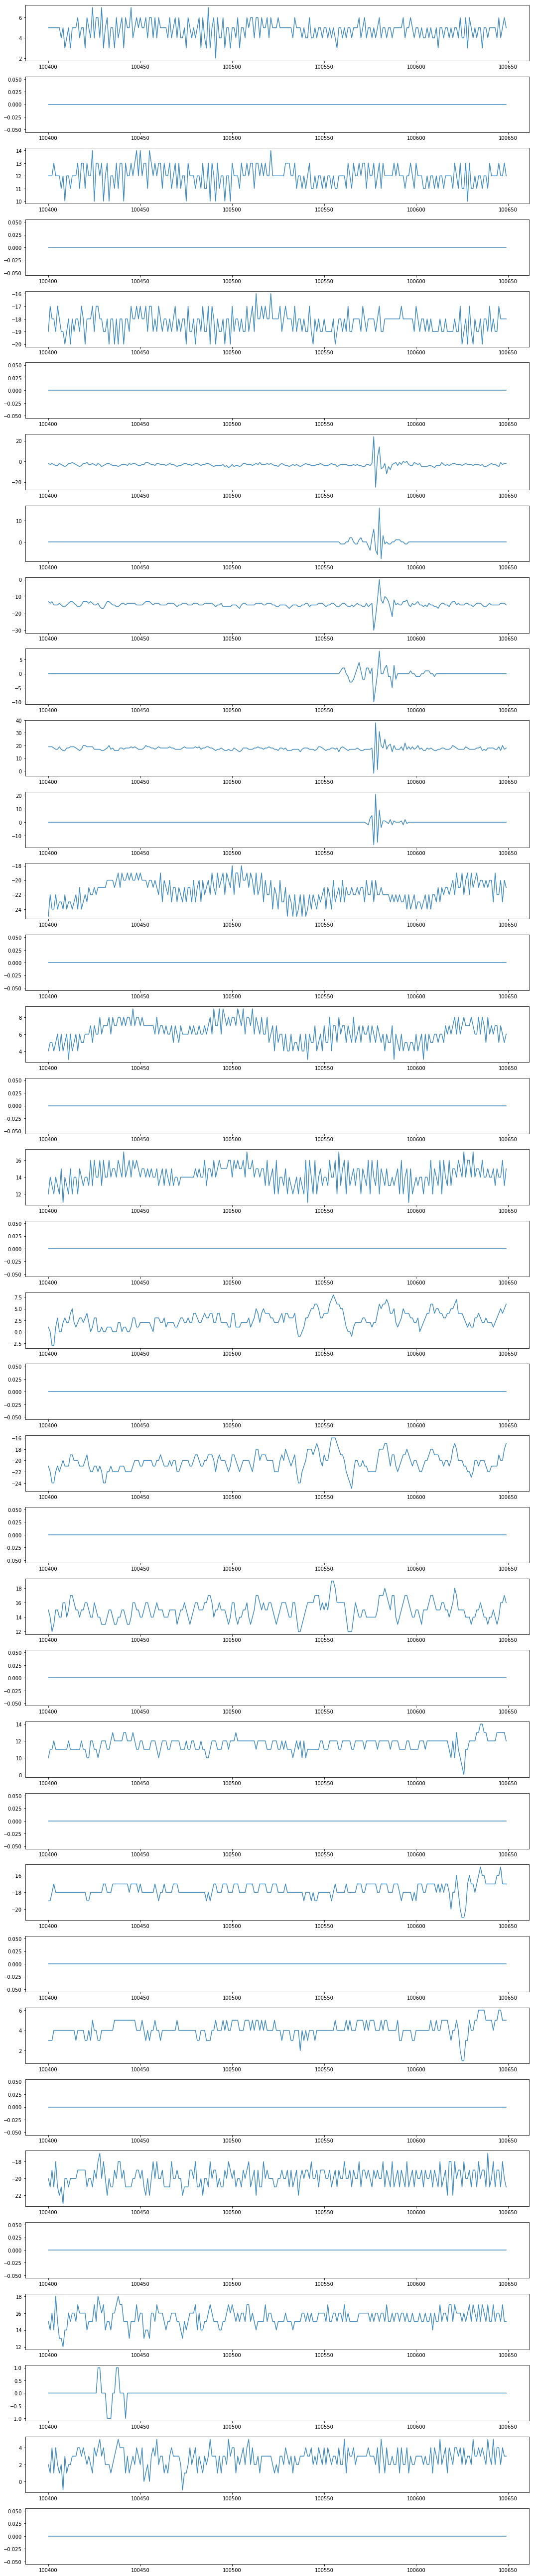

In [15]:
plt.close('all')
plt.cla()
plt.clf()

# plot params
num_signals = 18

f, axs = plt.subplots(num_signals * 2, 1, sharex=False, sharey=False, figsize=(15, num_signals * 4))

for i in np.arange(0,num_signals):
    j = 2*i
    sampling_freq = 1
    beg, end = 100400, 100650
    t = np.arange(beg, end/sampling_freq)
    axs[j].plot(t, raw_signals[i,beg:end:sampling_freq], alpha=0.85)act
    axs[j+1].plot(t, pp_signals_2[i,beg:end:sampling_freq], alpha=0.85)
    f.tight_layout()
plt.savefig('../visualizations/preprocess_demo_1.png')

**OK|NOK raw and preprocessed sample visualization**

<Figure size 432x288 with 0 Axes>

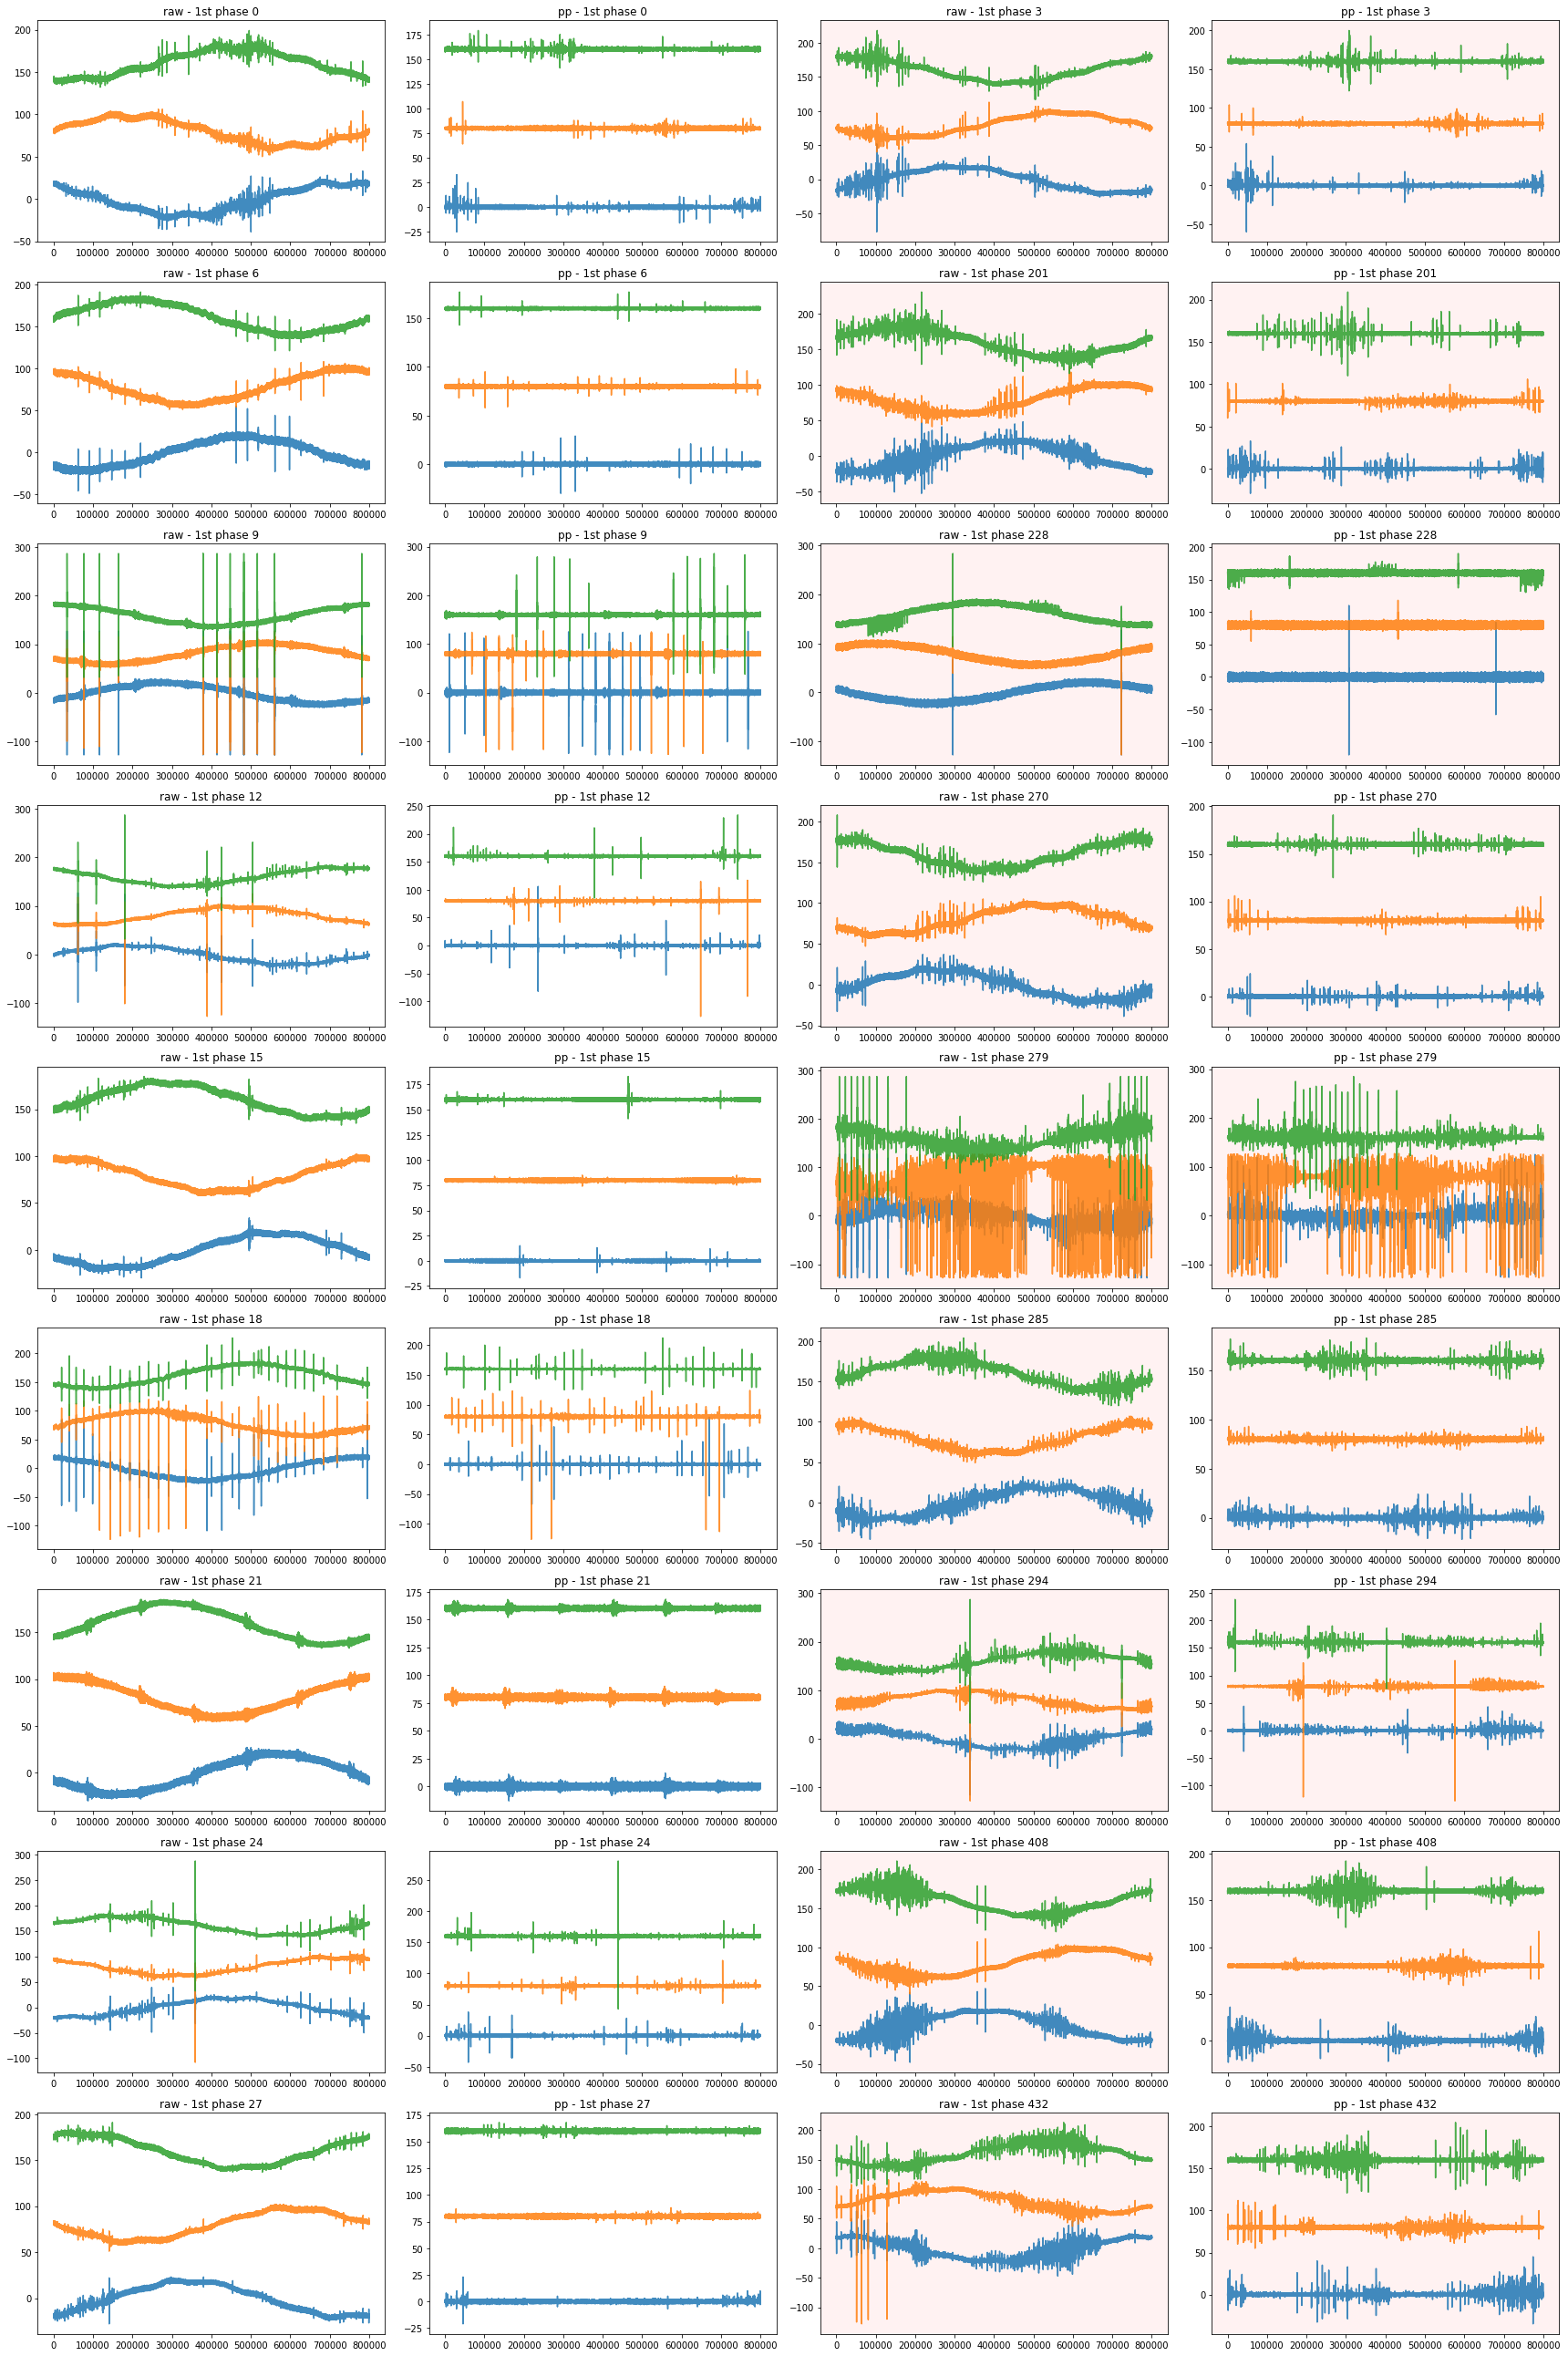

In [10]:
plt.close('all')
plt.cla()
plt.clf()

# plot params
num_signals = 9
samp_freq = 1

f, axs = plt.subplots(num_signals, 2 * 2, sharex=False, sharey=False, figsize=(2 * 2 * 6, num_signals * 4))

for k, (title, facecolor) in enumerate(zip(['OK', 'KO'], [(1, 1, 1), (1, 0.95, 0.95)])):

    # Grab first num_signals (either OK or KO depending on k) (might be grabbing partial OK/KO - ToDo)
    sig_ids = []
    for line in meta_train.values[::3,:]:
        if k == 0: # OK signals
            if line[-1] == 0:
                sig_ids.append(line[0])
                if len(sig_ids) == num_signals:
                    break # Done collecting
        else: # KO signals
            if line[-1] == 1:
                sig_ids.append(line[0])
                if len(sig_ids) == num_signals:
                    break # Done collecting
    
    for j, sig_type in enumerate(['raw', 'pp']):     
        t = np.arange(0, raw_signals.shape[1]/samp_freq)
        for i, sig_id in enumerate(sig_ids):
            axs[i,j + k*2].set_title(f'{sig_type} - 1st phase {sig_id:d}')
            for phase in [0,1,2]:
            
                if sig_type=='raw':
                    y = raw_signals[sig_id+phase, ::samp_freq] + phase * 80
                elif sig_type=='pp':
                    y = pp_signals[sig_id+phase, ::samp_freq] + phase * 80
                else:
                    raise ValueError('Unknown signal type')
                    
                axs[i,j + k*2].plot(t, y, alpha=0.85)
                axs[i,j + k*2].set_facecolor(facecolor)
                
    f.tight_layout()
plt.savefig('../visualizations/preprocess_alligned_ok_nok_db20_mp.png')

**OK|NOK preprocessed massive sample visualization**

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import glob, os, tqdm, gc
old_full_path = os.getcwd()
os.chdir(old_full_path + '/../code/')
from false_pos_suppression import fps
os.chdir(old_full_path)

In [5]:
# Load selected signals
print(os.getcwd())
dir_list = [f'../preprocessed_data/pp_train_db20/pp_train_db20_{num:d}.npy' for num in range(100)]
pp_signals = np.vstack([np.load(p) for p in dir_list])

# Load metadata as well
meta_train, meta_test = pd.read_csv('../data/metadata_train.csv'), pd.read_csv('../data/metadata_test.csv')

# Load oof preds
oof_preds = pd.read_hdf('../level_1_preds/lgbm_v23_0.6609_pp_oof.h5').values[:, 0]

/Users/miguelrita/Documents/Kaggle/remote_three/notebooks


In [10]:
visu_subdir = '../visualizations/db20_no_fps'
false_sup = False

fpath = os.getcwd() + '/' + visu_subdir
if not os.path.exists(fpath):
    os.mkdir(fpath)

# plot params
offset_between_phases = 10
num_signals_per_page = 5
num_pages = 20#int(np.ceil(pp_signals.shape[0]/3/num_signals_per_page))
samp_freq = 1

# inits
t = np.arange(0, pp_signals.shape[1]/samp_freq)
last_OK_id, last_KO_id = 0, 0

for page in tqdm.tqdm(range(num_pages), total=num_pages):

    f, axs = plt.subplots(num_signals_per_page, 2, sharex=True, sharey=True, figsize=(2 * 16, num_signals_per_page * 4))
    
    for k, (title, facecolor) in enumerate(zip(['OK', 'KO'], [(1, 1, 1), (1, 0.95, 0.95)])):

        # Grab first num_signals (either OK or KO depending on k)
        sig_ids = []
        tgts = []
        
        if k == 0: # OK signals
            
            if last_OK_id >= meta_train.shape[0]: # We got to the end, with last page completely filled
                last_OK_id = 0 
            
            signal_ids_3 = np.reshape(meta_train['signal_id'].values, (int(meta_train['signal_id'].shape[0]/3),-1))
            targets_3 = np.reshape(meta_train['target'].values, (int(meta_train['target'].shape[0]/3),-1))
            
            for line, (sig_id_vec, tgt_vec) in enumerate(zip(signal_ids_3[last_OK_id:], targets_3[last_OK_id:])):
                if np.sum(tgt_vec) == 0:
                    sig_ids.append(sig_id_vec)
                    tgts.append(tgt_vec)
                    
                    if len(sig_ids) == num_signals_per_page:
                        last_OK_id += line + 1     
                        break # Done collecting
                        
            if len(sig_ids) < num_signals_per_page: # We got to the end, not enough sigs to fill last page
                last_OK_id = 0
                                          
        else: # KO signals
            
            if last_KO_id >= meta_train.shape[0]: # We got to the end, with last page completely filled
                last_KO_id = 0
            
            signal_ids_3 = np.reshape(meta_train['signal_id'].values, (int(meta_train['signal_id'].shape[0]/3),-1))
            targets_3 = np.reshape(meta_train['target'].values, (int(meta_train['target'].shape[0]/3),-1))
            
            for line, (sig_id_vec, tgt_vec) in enumerate(zip(signal_ids_3[last_KO_id:], targets_3[last_KO_id:])):
                if np.sum(tgt_vec) >= 1:
                    sig_ids.append(sig_id_vec)
                    tgts.append(tgt_vec)
                    if len(sig_ids) == num_signals_per_page:
                        last_KO_id += line + 1      
                        break # Done collecting
            
            if len(sig_ids) < num_signals_per_page: # We got to the end, not enough sigs to fill last page
                last_KO_id = 0          

        for i, (sig_id_vec, tgt_vec) in enumerate(zip(sig_ids, tgts)):
            p0, p1, p2 = oof_preds[sig_id_vec[0]], oof_preds[sig_id_vec[1]], oof_preds[sig_id_vec[2]]
            axs[i,k].set_title(f'{title} - Phases : {sig_id_vec} - Targets : {tgt_vec} - Preds : {p0:.2f} {p1:.2f} {p2:.2f}')
            for phase,sig_id in enumerate(sig_id_vec):
                y = pp_signals[sig_id, ::samp_freq]
                
                if false_sup:
                    peak_heights, peak_widths, peak_ixs = fps(
                        signal=y,
                        min_height=2,
                        max_height=20,
                        ratio_range=.25,
                        max_distance=30,
                        clean_distance=500,
                        rel_height=.1,
                    )
                    y_fps = np.zeros(shape=y.shape)
                    y_fps[peak_ixs] = peak_heights
                    y_fps = y_fps + (phase-1) * offset_between_phases
                
                    axs[i,k].plot(t, y_fps, alpha=0.85)
                else:
                    y = y + (phase-1) * offset_between_phases
                    axs[i,k].plot(t, y, alpha=0.85)
                    
                axs[i,k].set_facecolor(facecolor)
                axs[i,k].set_ylim([-18,18])

    f.tight_layout()
    plt.savefig(visu_subdir + f'/preprocess_only_page_{page:d}.png')
    plt.close('all')
    plt.cla()
    plt.clf()
    del f, axs
    gc.collect()

100%|██████████| 20/20 [02:01<00:00,  6.05s/it]


<Figure size 432x288 with 0 Axes>